In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Added for heatmap plotting
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

# TensorFlow/Keras Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# ----------------------------------------------------------------------
# --- 1. DATA PATH DEFINITION AND LOADING ---
# ----------------------------------------------------------------------

In [5]:

LOCAL_FILE_PATH = "/content/sample_data/darknet.csv"
print(f"Attempting to load data from: {LOCAL_FILE_PATH}")

df = None
delimiters = [',', ';', '\t', '|']  # Common delimiters to try
for sep in delimiters:
    try:
        # Use on_bad_lines='skip' to skip lines with parsing errors
        df = pd.read_csv(LOCAL_FILE_PATH, sep=sep, low_memory=False, on_bad_lines='skip')
        print(f"Attempted loading with separator '{sep}'. Initial shape: {df.shape}")
        # DEBUGGING CHECK: Verify that columns were parsed correctly
        if df.shape[1] > 1:
            print(f"Data successfully loaded with separator '{sep}'.")
            break # Exit loop if loading is successful with multiple columns
        else:
            print(f"Loading with separator '{sep}' resulted in single column, trying other delimiters.")

    except Exception as e:
        print(f"An error occurred while loading data with separator '{sep}': {e}")

if df is None or df.shape[1] <= 1:
    print("\nERROR: Could not load data with a suitable delimiter. Please check the file's content and format.")
    # You can inspect the first line to see the delimiter
    try:
        with open(LOCAL_FILE_PATH, 'r') as f:
            print("First line of file:", f.readline())
    except Exception as e:
        print(f"Could not read the first line of the file: {e}")
    # exit() # Removed exit() to allow subsequent code to be examined
else:
    print(f"Data successfully loaded. Initial shape: {df.shape}")

Attempting to load data from: /content/sample_data/darknet.csv
Attempted loading with separator ','. Initial shape: (141530, 85)
Data successfully loaded with separator ','.
Data successfully loaded. Initial shape: (141530, 85)


# ----------------------------------------------------------------------
# --- 2. DATA CLEANING AND PREPROCESSING ---
# ----------------------------------------------------------------------

In [6]:
# Ensure a DataFrame is loaded before proceeding with cleaning
if df is not None and df.shape[1] > 1:
    # Drop irrelevant/non-ML columns
    df.drop(columns=['Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'Label.1'],
            inplace=True, errors='ignore')

    # Fix column names (remove leading/trailing spaces)
    df.columns = df.columns.str.strip()

    # Handle Infinite/NaN Values
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Coerce rate features to numeric
    rate_columns = ['Flow Bytes/s', 'Flow Packets/s']
    for col in rate_columns:
        if col in df.columns: # Check if column exists before trying to convert
            df[col] = pd.to_numeric(df[col], errors='coerce')
        else:
            print(f"Warning: Column '{col}' not found in the dataframe. Skipping conversion.")


    df.dropna(inplace=True) # Final drop of rows with any NaN values

    # Label Encoding for object/text columns
    label_encoder_map = {} # To store encoders for later decoding
    for column in ['Protocol', 'Label']:
        if column in df.columns and df[column].dtype == 'object':
            le = LabelEncoder()
            # Convert to string before encoding to handle mixed types gracefully
            df[column] = le.fit_transform(df[column].astype(str))
            label_encoder_map[column] = le # Store the encoder
            print(f"Encoded column: {column}")
else:
    print("Skipping preprocessing due to data loading error.")

# ----------------------------------------------------------------------
# --- 3. DEFINE X, Y, NORMALIZE, AND SPLIT ---
# ----------------------------------------------------------------------
TARGET_COLUMN = 'Label'
X, Y = None, None
if df is not None and TARGET_COLUMN in df.columns:
    X = df.drop(TARGET_COLUMN, axis=1)
    Y = df[TARGET_COLUMN]

    # Store unique class names for the classification report
    if 'Label' in label_encoder_map:
        label_names = label_encoder_map['Label'].classes_
    else:
        label_names = [str(i) for i in sorted(Y.unique())]

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns)

    # One-hot encode the target variable Y
    Y_onehot = to_categorical(Y)

    # Train/Test Split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y_onehot, test_size=0.2, random_state=42)

    # Reshape for LSTM: (samples, timesteps, features)
    n_features = X_train.shape[1]
    n_timesteps = 1 # Assuming a single timestep input for each sample
    X_train_reshaped = np.reshape(X_train.values, (X_train.shape[0], n_timesteps, n_features))
    X_test_reshaped = np.reshape(X_test.values, (X_test.shape[0], n_timesteps, n_features))

    print(f"\nFinal training samples: {X_train.shape[0]}")
    print(f"Number of features: {n_features}")
else:
    print("\nERROR: Cannot proceed. Target column or data not ready after preprocessing.")

Encoded column: Label

Final training samples: 113184
Number of features: 79


# ----------------------------------------------------------------------
# --- 4. MODEL DEFINITION AND TRAINING ---
# ----------------------------------------------------------------------

In [7]:
if 'X_train_reshaped' in locals() and X_train_reshaped.shape[0] > 0:
    n_classes = Y_test.shape[1]
    model = Sequential([
        # LSTM layer with a single time step input per sample
        LSTM(units=50, input_shape=(n_timesteps, n_features)),
        # Output layer for multi-class classification
        Dense(units=n_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    print("\n--- Model Training Starting (Max 50 Epochs with Early Stopping) ---")
    history = model.fit(
        X_train_reshaped,
        Y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_test_reshaped, Y_test),
        callbacks=[early_stopping],
        verbose=1
    )
    print("--- Model Training Complete ---")
else:
    print("Skipping model definition and training due to missing data.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



--- Model Training Starting (Max 50 Epochs with Early Stopping) ---
Epoch 1/50
3537/3537 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8639 - loss: 0.4158 - val_accuracy: 0.9415 - val_loss: 0.1866
Epoch 2/50
3537/3537 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9432 - loss: 0.1768 - val_accuracy: 0.9482 - val_loss: 0.1631
Epoch 3/50
3537/3537 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9485 - loss: 0.1574 - val_accuracy: 0.9508 - val_loss: 0.1508
Epoch 4/50
3537/3537 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9541 - loss: 0.1421 - val_accuracy: 0.9523 - val_loss: 0.1403
Epoch 5/50
3537/3537 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9552 - loss: 0.1320 - val_accuracy: 0.9555 - val_loss: 0.1307
Epoch 6/50
3537/3537 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9575 - loss: 0.1222 - val_accuracy: 0.9540 - val_loss: 0.1280
Epoch 7/50
3537/3537 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9593 - loss: 0.1162 - val_accuracy: 0.9573 - val_loss: 0.1229
Epoch 8/50
353

# ----------------------------------------------------------------------
# --- 5. EVALUATION AND PLOTTING ---
# ----------------------------------------------------------------------


Final Test Accuracy: 96.59%
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

--- Classification Report (F1-Score, Precision, Recall) ---
              precision    recall  f1-score   support

     Non-Tor       1.00      1.00      1.00     18655
      NonVPN       0.91      0.90      0.90      4752
         Tor       0.98      0.86      0.91       282
         VPN       0.90      0.91      0.91      4608

    accuracy                           0.97     28297
   macro avg       0.95      0.92      0.93     28297
weighted avg       0.97      0.97      0.97     28297


--- Confusion Matrix (Raw Data) ---
[[18607    24     0    24]
 [   44  4287     2   419]
 [    0    34   242     6]
 [   25   383     4  4196]]

Successfully saved plots: 'accuracy_loss_plot.png', 'confusion_matrix_heatmap.png', and 'classification_metrics_per_class.png'


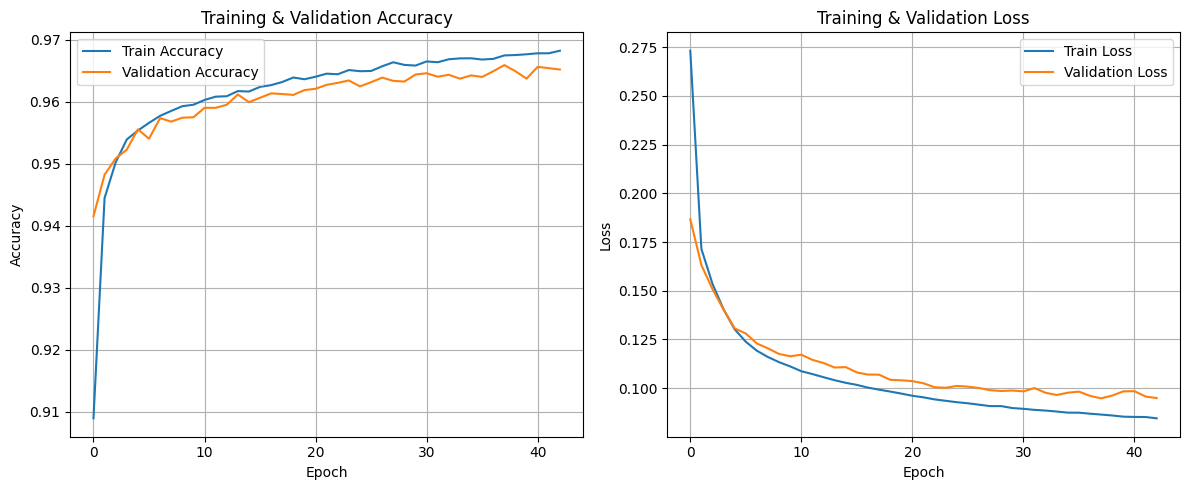

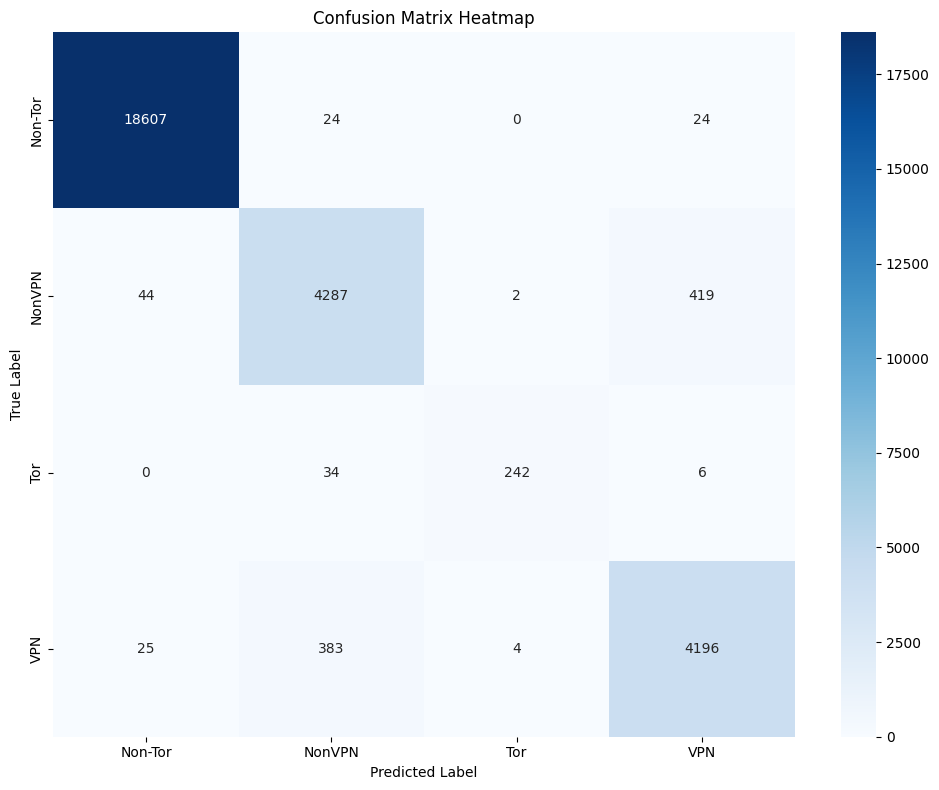

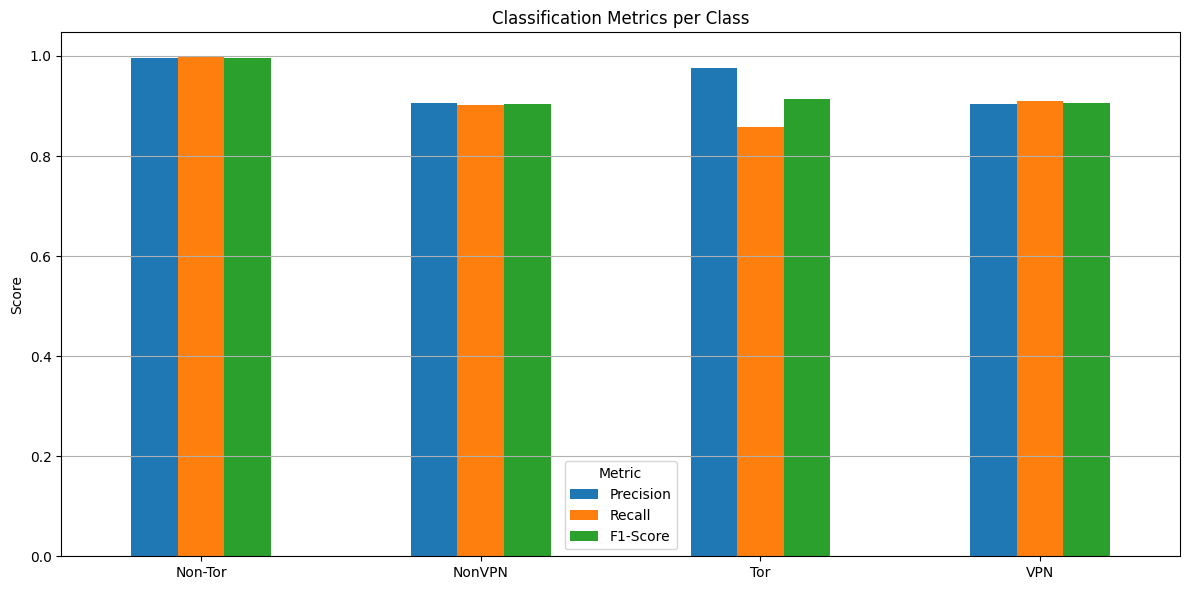

In [9]:
if 'model' in locals():
    # Model Evaluation
    loss, accuracy = model.evaluate(X_test_reshaped, Y_test, verbose=0)
    print(f"\nFinal Test Accuracy: {accuracy*100:.2f}%")

    Y_pred_proba = model.predict(X_test_reshaped)
    Y_pred_classes = np.argmax(Y_pred_proba, axis=1)
    Y_true_classes = np.argmax(Y_test, axis=1)

    print("\n--- Classification Report (F1-Score, Precision, Recall) ---")
    # Note: Requires label_names to be defined (as in the complete original script)
    print(classification_report(Y_true_classes, Y_pred_classes, target_names=label_names, zero_division=0))

    print("\n--- Confusion Matrix (Raw Data) ---")
    print(confusion_matrix(Y_true_classes, Y_pred_classes))

    # --- 5.1 Plotting Accuracy and Loss ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    # Note: Requires 'history' object from model.fit()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    # SAVING THE PLOT
    plt.savefig('accuracy_loss_plot.png')


    # --- 5.2 Plotting Confusion Matrix (Heatmap) ---
    cm = confusion_matrix(Y_true_classes, Y_pred_classes)
    plt.figure(figsize=(10, 8))
    # Note: Requires 'seaborn as sns' import
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.title('Confusion Matrix Heatmap')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    # SAVING THE PLOT
    plt.savefig('confusion_matrix_heatmap.png')


    # --- 5.3 Plotting Classification Metrics (Precision, Recall, F1-Score) ---
    # Calculate metrics for each class
    # Note: Requires 'precision_recall_fscore_support' import
    metrics = precision_recall_fscore_support(Y_true_classes, Y_pred_classes, average=None, zero_division=0)
    metrics_df = pd.DataFrame({
        'Precision': metrics[0],
        'Recall': metrics[1],
        'F1-Score': metrics[2]
    }, index=label_names)

    plt.figure(figsize=(12, 6))
    # Using pandas plot on the DataFrame for a grouped bar chart
    metrics_df.plot(kind='bar', ax=plt.gca())
    plt.title('Classification Metrics per Class')
    plt.ylabel('Score')
    plt.xticks(rotation=0)
    plt.legend(title='Metric')
    plt.grid(axis='y')
    plt.tight_layout()
    # SAVING THE PLOT
    plt.savefig('classification_metrics_per_class.png')

    print("\nSuccessfully saved plots: 'accuracy_loss_plot.png', 'confusion_matrix_heatmap.png', and 'classification_metrics_per_class.png'")

else:
    print("Skipping evaluation and plotting due to model training failure.")